## Introduction ##

This is my first work of machine learning. the notebook is written in python and has inspired from ["Exploring Survival on Titanic" by Megan Risdal, a Kernel in R on Kaggle][1].


  [1]: https://www.kaggle.com/mrisdal/titanic/exploring-survival-on-the-titanic

In [19]:
%matplotlib inline
import numpy as np
import pandas as pd
import re as re

train = pd.read_csv('../../Data/train.csv', header = 0, dtype={'Age': np.float64})
test  = pd.read_csv('../../Data/test.csv' , header = 0, dtype={'Age': np.float64})
full_data = [train, test]

print (train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


In [20]:
from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
import matplotlib.patches as patches
from aif360.algorithms.preprocessing import Reweighing
#from packages import *
#from ml_fairness import *
import matplotlib.pyplot as plt
import seaborn as sns



from IPython.display import Markdown, display

# Feature Engineering #

## 1. Pclass ##
there is no missing value on this feature and already a numerical value. so let's check it's impact on our train set.

In [21]:
print (train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean())

   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363


## 2. Sex ##

In [22]:
print (train[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean())

      Sex  Survived
0  female  0.742038
1    male  0.188908


## 3. SibSp and Parch ##
With the number of siblings/spouse and the number of children/parents we can create new feature called Family Size.

In [23]:
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
print (train[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean())

   FamilySize  Survived
0           1  0.303538
1           2  0.552795
2           3  0.578431
3           4  0.724138
4           5  0.200000
5           6  0.136364
6           7  0.333333
7           8  0.000000
8          11  0.000000


it seems has a good effect on our prediction but let's go further and categorize people to check whether they are alone in this ship or not.

In [24]:
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
print (train[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean())

   IsAlone  Survived
0        0  0.505650
1        1  0.303538


good! the impact is considerable.

## 4. Embarked ##
the embarked feature has some missing value. and we try to fill those with the most occurred value ( 'S' ).

In [25]:
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
print (train[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean())

  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.339009


## 5. Fare ##
Fare also has some missing value and we will replace it with the median. then we categorize it into 4 ranges.

In [26]:
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)
print (train[['CategoricalFare', 'Survived']].groupby(['CategoricalFare'], as_index=False).mean())

   CategoricalFare  Survived
0   (-0.001, 7.91]  0.197309
1   (7.91, 14.454]  0.303571
2   (14.454, 31.0]  0.454955
3  (31.0, 512.329]  0.581081


## 6. Age ##
we have plenty of missing values in this feature. # generate random numbers between (mean - std) and (mean + std).
then we categorize age into 5 range.

In [27]:
for dataset in full_data:
    age_avg 	   = dataset['Age'].mean()
    age_std 	   = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
    
train['CategoricalAge'] = pd.cut(train['Age'], 5)

print (train[['CategoricalAge', 'Survived']].groupby(['CategoricalAge'], as_index=False).mean())

  CategoricalAge  Survived
0  (-0.08, 16.0]  0.517241
1   (16.0, 32.0]  0.354023
2   (32.0, 48.0]  0.373077
3   (48.0, 64.0]  0.434783
4   (64.0, 80.0]  0.090909



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## 7. Name ##
inside this feature we can find the title of people.

In [28]:
def get_title(name):
	title_search = re.search(' ([A-Za-z]+)\.', name)
	# If the title exists, extract and return it.
	if title_search:
		return title_search.group(1)
	return ""

for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)

print(pd.crosstab(train['Title'], train['Sex']))

Sex       female  male
Title                 
Capt           0     1
Col            0     2
Countess       1     0
Don            0     1
Dr             1     6
Jonkheer       0     1
Lady           1     0
Major          0     2
Master         0    40
Miss         182     0
Mlle           2     0
Mme            1     0
Mr             0   517
Mrs          125     0
Ms             1     0
Rev            0     6
Sir            0     1


 so we have titles. let's categorize it and check the title impact on survival rate.

In [29]:
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

print (train[['Title', 'Survived']].groupby(['Title'], as_index=False).mean())

    Title  Survived
0  Master  0.575000
1    Miss  0.702703
2      Mr  0.156673
3     Mrs  0.793651
4    Rare  0.347826


# Data Cleaning #
great! now let's clean our data and map our features into numerical values.

In [30]:
for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 1, 'male': 0} ).astype(int)
    
    # Mapping titles
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] 						        = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] 							        = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age'] 					       = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age']                           = 4

# Feature Selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp',\
                 'Parch', 'FamilySize']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)

test  = test.drop(drop_elements, axis = 1)

print (train.head(10))
train_df = train
train = train.values
test  = test.values

   Survived  Pclass  Sex  Age  Fare  Embarked  IsAlone  Title
0         0       3    0    1     0         0        0      1
1         1       1    1    2     3         1        0      3
2         1       3    1    1     1         0        1      2
3         1       1    1    2     3         0        0      3
4         0       3    0    2     1         0        1      1
5         0       3    0    2     1         2        1      1
6         0       1    0    3     3         0        1      1
7         0       3    0    0     2         0        0      4
8         1       3    1    1     1         0        0      3
9         1       2    1    0     2         1        0      3


good! now we have a clean dataset and ready to predict. let's find which classifier works better on this dataset. 

# Classifier Comparison #

<AxesSubplot:title={'center':'Classifier Accuracy'}, xlabel='Accuracy', ylabel='Classifier'>

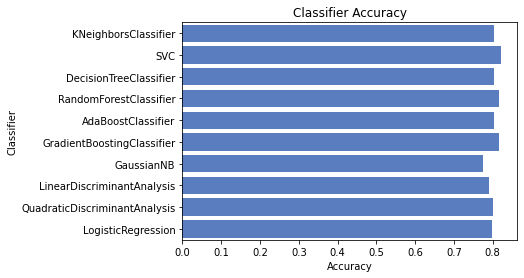

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

classifiers = [
    KNeighborsClassifier(3),
    SVC(probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
	AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    LogisticRegression()]

log_cols = ["Classifier", "Accuracy"]
log 	 = pd.DataFrame(columns=log_cols)

sss = StratifiedShuffleSplit(n_splits=10, test_size=0.1, random_state=0)

X = train[0::, 1::]
y = train[0::, 0]

acc_dict = {}

for train_index, test_index in sss.split(X, y):
	X_train, X_test = X[train_index], X[test_index]
	y_train, y_test = y[train_index], y[test_index]
	
	for clf in classifiers:
		name = clf.__class__.__name__
		clf.fit(X_train, y_train)
		train_predictions = clf.predict(X_test)
		acc = accuracy_score(y_test, train_predictions)
		if name in acc_dict:
			acc_dict[name] += acc
		else:
			acc_dict[name] = acc

for clf in acc_dict:
	acc_dict[clf] = acc_dict[clf] / 10.0
	log_entry = pd.DataFrame([[clf, acc_dict[clf]]], columns=log_cols)
	log = log.append(log_entry)

plt.xlabel('Accuracy')
plt.title('Classifier Accuracy')

sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")

# Prediction #
now we can use SVC classifier to predict our data.

In [13]:
candidate_classifier = SVC()
candidate_classifier.fit(train[0::, 1::], train[0::, 0])
result = candidate_classifier.predict(test)

## Fairness

In [32]:
# This DataFrame is created to stock differents models and fair metrics that we produce in this notebook
algo_metrics = pd.DataFrame(columns=['model', 'fair_metrics', 'prediction', 'probs'])

def add_to_df_algo_metrics(algo_metrics, model, fair_metrics, preds, probs, name):
    return algo_metrics.append(pd.DataFrame(data=[[model, fair_metrics, preds, probs]], columns=['model', 'fair_metrics', 'prediction', 'probs'], index=[name]))

In [33]:
def fair_metrics(dataset, pred, pred_is_dataset=False):
    if pred_is_dataset:
        dataset_pred = pred
    else:
        dataset_pred = dataset.copy()
        dataset_pred.labels = pred
    
    cols = ['statistical_parity_difference', 'equal_opportunity_difference', 'average_abs_odds_difference',  'disparate_impact', 'theil_index']
    obj_fairness = [[0,0,0,1,0]]
    
    fair_metrics = pd.DataFrame(data=obj_fairness, index=['objective'], columns=cols)
    
    for attr in dataset_pred.protected_attribute_names:
        idx = dataset_pred.protected_attribute_names.index(attr)
        privileged_groups =  [{attr:dataset_pred.privileged_protected_attributes[idx][0]}] 
        unprivileged_groups = [{attr:dataset_pred.unprivileged_protected_attributes[idx][0]}] 
        
        classified_metric = ClassificationMetric(dataset, 
                                                     dataset_pred,
                                                     unprivileged_groups=unprivileged_groups,
                                                     privileged_groups=privileged_groups)

        metric_pred = BinaryLabelDatasetMetric(dataset_pred,
                                                     unprivileged_groups=unprivileged_groups,
                                                     privileged_groups=privileged_groups)

        acc = classified_metric.accuracy()

        row = pd.DataFrame([[metric_pred.mean_difference(),
                                classified_metric.equal_opportunity_difference(),
                                classified_metric.average_abs_odds_difference(),
                                metric_pred.disparate_impact(),
                                classified_metric.theil_index()]],
                           columns  = cols,
                           index = [attr]
                          )
        fair_metrics = fair_metrics.append(row)    
    
    fair_metrics = fair_metrics.replace([-np.inf, np.inf], 2)
        
    return fair_metrics

def plot_fair_metrics(fair_metrics):
    fig, ax = plt.subplots(figsize=(20,4), ncols=5, nrows=1)

    plt.subplots_adjust(
        left    =  0.125, 
        bottom  =  0.1, 
        right   =  0.9, 
        top     =  0.9, 
        wspace  =  .5, 
        hspace  =  1.1
    )

    y_title_margin = 1.2

    plt.suptitle("Fairness metrics", y = 1.09, fontsize=20)
    sns.set(style="dark")

    cols = fair_metrics.columns.values
    obj = fair_metrics.loc['objective']
    size_rect = [0.2,0.2,0.2,0.4,0.25]
    rect = [-0.1,-0.1,-0.1,0.8,0]
    bottom = [-1,-1,-1,0,0]
    top = [1,1,1,2,1]
    bound = [[-0.1,0.1],[-0.1,0.1],[-0.1,0.1],[0.8,1.2],[0,0.25]]

    display(Markdown("### Check bias metrics :"))
    display(Markdown("A model can be considered bias if just one of these five metrics show that this model is biased."))
    for attr in fair_metrics.index[1:len(fair_metrics)].values:
        display(Markdown("#### For the %s attribute :"%attr))
        check = [bound[i][0] < fair_metrics.loc[attr][i] < bound[i][1] for i in range(0,5)]
        display(Markdown("With default thresholds, bias against unprivileged group detected in **%d** out of 5 metrics"%(5 - sum(check))))

    for i in range(0,5):
        plt.subplot(1, 5, i+1)
        ax = sns.barplot(x=fair_metrics.index[1:len(fair_metrics)], y=fair_metrics.iloc[1:len(fair_metrics)][cols[i]])
        
        for j in range(0,len(fair_metrics)-1):
            a, val = ax.patches[j], fair_metrics.iloc[j+1][cols[i]]
            marg = -0.2 if val < 0 else 0.1
            ax.text(a.get_x()+a.get_width()/5, a.get_y()+a.get_height()+marg, round(val, 3), fontsize=15,color='black')

        plt.ylim(bottom[i], top[i])
        plt.setp(ax.patches, linewidth=0)
        ax.add_patch(patches.Rectangle((-5,rect[i]), 10, size_rect[i], alpha=0.3, facecolor="green", linewidth=1, linestyle='solid'))
        plt.axhline(obj[i], color='black', alpha=0.3)
        plt.title(cols[i])
        ax.set_ylabel('')    
        ax.set_xlabel('')

In [34]:
def get_fair_metrics_and_plot(data, model, plot=False, model_aif=False):
    pred = model.predict(data).labels if model_aif else model.predict(data.features)
    # fair_metrics function available in the metrics.py file
    fair = fair_metrics(data, pred)

    if plot:
        # plot_fair_metrics function available in the visualisations.py file
        # The visualisation of this function is inspired by the dashboard on the demo of IBM aif360 
        plot_fair_metrics(fair)
        display(fair)
    
    return fair

In [37]:
##train['Sex'] = train['Sex'].map( {'female': 1, 'male': 0} ).astype(int)
train_df

#features = ["Pclass", "Sex", "SibSp", "Parch", "Survived"]
#X = pd.get_dummies(train_data[features])

,Survived,Pclass,Sex,Age,Fare,Embarked,IsAlone,Title
0,0,3,0,1,0,0,0,1
1,1,1,1,2,3,1,0,3
2,1,3,1,1,1,0,1,2
3,1,1,1,2,3,0,0,3
4,0,3,0,2,1,0,1,1
...,...,...,...,...,...,...,...,...
886,0,2,0,1,1,0,1,5
887,1,1,1,1,2,0,1,2
888,0,3,1,2,2,0,0,2
889,1,1,0,1,2,1,1,1


In [39]:
privileged_groups = [{'Sex': 1}]
unprivileged_groups = [{'Sex': 0}]
dataset_orig = StandardDataset(train_df,
                                  label_name='Survived',
                                  protected_attribute_names=['Sex'],
                                  favorable_classes=[1],
                                  privileged_classes=[[1]])



In [40]:
metric_orig_train = BinaryLabelDatasetMetric(dataset_orig, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

#### Original training dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.553130


In [41]:
import ipynbname
nb_fname = ipynbname.name()
nb_path = ipynbname.path()

from sklearn.ensemble import AdaBoostClassifier
import pickle

data_orig_train, data_orig_test = dataset_orig.split([0.7], shuffle=True)
X_train = data_orig_train.features
y_train = data_orig_train.labels.ravel()

X_test = data_orig_test.features
y_test = data_orig_test.labels.ravel()
num_estimators = 100

model = AdaBoostClassifier(n_estimators=1)

mdl = model.fit(X_train, y_train)
with open('../../Results/AdaBoost/' + nb_fname + '.pkl', 'wb') as f:
        pickle.dump(mdl, f)

with open('../../Results/AdaBoost/' + nb_fname + '_Train' + '.pkl', 'wb') as f:
    pickle.dump(data_orig_train, f) 
    
with open('../../Results/AdaBoost/' + nb_fname + '_Test' + '.pkl', 'wb') as f:
    pickle.dump(data_orig_test, f) 

In [42]:
from csv import writer
from sklearn.metrics import accuracy_score, f1_score

final_metrics = []
accuracy = []
f1= []

for i in range(1,num_estimators+1):
    
    model = AdaBoostClassifier(n_estimators=i)
    
    mdl = model.fit(X_train, y_train)
    yy = mdl.predict(X_test)
    accuracy.append(accuracy_score(y_test, yy))
    f1.append(f1_score(y_test, yy))
    fair = get_fair_metrics_and_plot(data_orig_test, mdl)                           
    fair_list = fair.iloc[1].tolist()
    fair_list.insert(0, i)
    final_metrics.append(fair_list)


In [43]:
import numpy as np
final_result = pd.DataFrame(final_metrics)
final_result[4] = np.log(final_result[4])
final_result = final_result.transpose()
final_result.loc[0] = f1  # add f1 and acc to df
acc = pd.DataFrame(accuracy).transpose()
acc = acc.rename(index={0: 'accuracy'})
final_result = pd.concat([acc,final_result])
final_result = final_result.rename(index={0: 'f1', 1: 'statistical_parity_difference', 2: 'equal_opportunity_difference', 3: 'average_abs_odds_difference', 4: 'disparate_impact', 5: 'theil_index'})
final_result.columns = ['T' + str(col) for col in final_result.columns]
final_result.insert(0, "classifier", final_result['T' + str(num_estimators - 1)])   ##Add final metrics add the beginning of the df
final_result.to_csv('../../Results/AdaBoost/' + nb_fname + '.csv')
final_result

,classifier,T0,T1,T2,T3,T4,T5,T6,T7,T8,...,T90,T91,T92,T93,T94,T95,T96,T97,T98,T99
accuracy,0.787313,0.764925,0.764925,0.779851,0.750000,0.783582,0.779851,0.783582,0.791045,0.787313,...,0.787313,0.787313,0.787313,0.787313,0.787313,0.787313,0.787313,0.787313,0.787313,0.787313
f1,0.729858,0.729614,0.729614,0.735426,0.621469,0.715686,0.730594,0.715686,0.730769,0.727273,...,0.729858,0.729858,0.729858,0.727273,0.729858,0.729858,0.727273,0.729858,0.727273,0.729858
statistical_parity_difference,-0.814846,-0.867052,-0.867052,-0.908549,-0.489565,-0.578096,-0.947977,-0.708549,-0.799574,-0.793794,...,-0.814846,-0.814846,-0.814846,-0.793794,-0.814846,-0.814846,-0.793794,-0.814846,-0.793794,-0.814846
equal_opportunity_difference,-0.775214,-0.731707,-0.731707,-0.766974,-0.477917,-0.531641,-0.853659,-0.759064,-0.761701,-0.761701,...,-0.775214,-0.775214,-0.775214,-0.761701,-0.775214,-0.775214,-0.761701,-0.775214,-0.761701,-0.775214
average_abs_odds_difference,0.702001,0.820399,0.820399,0.864548,0.322833,0.370799,0.915466,0.539705,0.675223,0.671435,...,0.702001,0.702001,0.702001,0.671435,0.702001,0.702001,0.671435,0.702001,0.671435,0.702001
disparate_impact,-2.545325,-2.017797,-2.017797,-2.503652,-2.248073,-1.713065,-2.956067,-2.277845,-2.608239,-2.521227,...,-2.545325,-2.545325,-2.545325,-2.521227,-2.545325,-2.545325,-2.521227,-2.545325,-2.521227,-2.545325
theil_index,0.179316,0.157679,0.157679,0.164565,0.265484,0.193705,0.171370,0.193705,0.181456,0.182624,...,0.179316,0.179316,0.179316,0.182624,0.179316,0.179316,0.182624,0.179316,0.182624,0.179316
